# Computing Landscape Metrics

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ai4er-cdt/gtc-biodiversity/main?filepath=notebooks%2F1-demo-landscape-metrics-comparison-to-pylandstats.ipynb)

This tutorial shows how to compute landscape level metrics using the `GeoGraph` package, and how these compare to `PyLandStats` metrics.

## 1. Imports

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import rioxarray as rxr
import geopandas as gpd

import pylandstats as pls

from geograph import GeoGraph
from geograph.constants import UTM35N
from geograph.demo.binder_constants import DATA_DIR, ROIS

# Parse geotif landcover data
chernobyl_path = lambda year: DATA_DIR / "chernobyl" / "esa_cci" / f"esa_cci_{year}_chernobyl.tif" 

# Parse ROIS
rois = gpd.read_file(ROIS)
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]

## 2. Loading Chernobyl Landcover Data (ESA CCI)

For this tutorial we will use the ESA CCI landcover dataset as an example to illustrate how
geographs enable us to reproduce the same metrics that traditional fragmentation software (pylandstats, fragstats)
produce. In this demo we will look specifically at the Chernobyl exclusion zone, so we reproject the satellite data to the right coordinate
system (UTM35N) and clip to the CEZ region of interest).

In [3]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

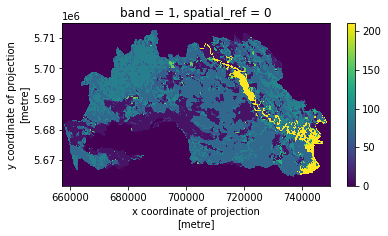

In [ ]:
# Loading raster data
cez_raster_2015 = clip_and_reproject(rxr.open_rasterio(chernobyl_path(2015)), clip_geometry=cez.geometry)

# Plot the data
fig, ax = plt.subplots(1, figsize=(6, 3))
cez_raster_2015.plot(cmap="viridis", ax=ax);

Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1999/1999 [00:01<00:00, 1147.76it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1999/1999 [00:00<00:00, 64434.03it/s]


Graph successfully loaded with 1999 nodes and 5117 edges.


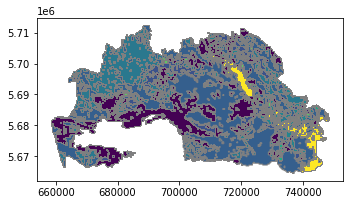

In [5]:
# Load geograph from the raster data (construction takes ~10s)
cez_graph_2015 = GeoGraph(data=cez_raster_2015.data, 
                          transform=cez_raster_2015.rio.transform(), 
                          mask=cez_raster_2015.data > 0,
                          crs=UTM35N, 
                          connectivity=8)

# Visualize geograph
fig, ax = plt.subplots(1, figsize=(6,3))
cez_graph_2015.df.plot("class_label", ax=ax, edgecolor="grey");

Next, we can calculate the metrics for this GeoGraph. 

## 3. Investigating metrics

Let us now investigate a couple of the standard metrics that are used in landscape ecology.
By default GeoGraph always uses the metrics of the CRS system that the data is in, so
meters in our case of UTM35N.

Conveniently, GeoGraph includes the units for us under the "unit" parameter.

### 3.1 Landscape level metrics

In [6]:
# Calculating the landscape total area
cez_graph_2015.get_metric("total_area", class_value=11)

Metric(value=21780000.0, name='total_area_class=11', description='Total area of all patches of class 11 in the graph.', variant='conventional', unit='CRS.unit**2')

In [7]:
# Calculating the landscape shannon index
cez_graph_2015.get_metric("shannon_diversity_index")

Metric(value=1.7805292346274288, name='shannon_diversity_index', description='SHDI approaches 0 when the entire landscape consists of a single patch, and increases as the number of classes increases and/or the proportional distribution of area among classes becomes more equitable.', variant='conventional', unit='dimensionless')

In [8]:
# Calculating the landscape simpson diversity index
cez_graph_2015.get_metric("simpson_diversity_index")

Metric(value=0.7753989062411218, name='simpson_diversity_index', description='Probability that any two pixels drawn at random will be of differentclass types', variant='conventional', unit='dimensionless')

#### 3.1.1 Comparison to pylandstats landscape level metrics


To convince us that these metrics are sensible, we compare to the python implementation [pylandstats](https://pylandstats.readthedocs.io/en/latest/index.html) of the popular FRAGSTATS package.
As we will see, GeoGraphs allow us to compute (almost - currently only limited by our time for implementing them) any metric that pylandstas supports. We will also see that the metrics agree, if we note the Caveat that pylandtats uses hecatres as base unit for computations, while GeoGraph uses the unit of the CRS of the underlying data (meters in our case of `UTM35N`).

In [9]:
cez_landscape_2015 = pls.Landscape(cez_raster_2015.data.squeeze(), res=(300,300) , nodata=0)

In [10]:
print("Shannon diversity index:")
print(f"\t Pylandstats: {cez_landscape_2015.shannon_diversity_index()}")
print(f"\t Geograph:    {cez_graph_2015.get_metric('shannon_diversity_index').value}")

Shannon diversity index:
	 Pylandstats: 1.7805292346274288
	 Geograph:    1.7805292346274288


In [11]:
print("Total area:")
print(f"\t Pylandstats: {cez_landscape_2015.total_area()} ha")
print(f"\t Geograph:    {cez_graph_2015.get_metric('total_area').value} meter^2")

Total area:
	 Pylandstats: 259758.0 ha
	 Geograph:    2597580000.0 meter^2


### 3.2 Class level metrics

On top of landscape level metrics, we might be interested in how different landcover classes are distributed across the landscape. For this purpose we can use class level metrics:

For a GeoGraph, we can request the metrics individually via the `get_metrics` method as before. If we want to have several metrics for multiple classes, we can also take the `get_class_metrics` shortcut. 
The GeoGraph caches the computations under the hood to speed up future computations.

In [12]:
cez_graph_2015.get_metric("proportion_of_landscape", class_value=10)

Metric(value=0.20178781789203798, name='proportion_of_landscape_class=10', description='The proportional abundance of 10 in the graph.', variant='conventional', unit='dimensionless')

In [13]:
cez_graph_2015.get_class_metrics(names = ["num_patches", "effective_mesh_size"], classes=[10,11,210])

,num_patches,effective_mesh_size
10,190,2.442215e+07
11,84,7.109694e+03
210,34,1.733824e+06


To get all metrics, simply omit the arguments.

In [14]:
cez_graph_2015.get_class_metrics()

,num_patches,avg_patch_area,total_area,proportion_of_landscape,patch_density,largest_patch_index,total_edge,edge_density,shape_index,effective_mesh_size
10,190,2.758737e+06,524160000.0,0.201788,7.314500e-08,0.093029,1771800.0,0.003380,19.347407,2.442215e+07
11,84,2.592857e+05,21780000.0,0.008385,3.233779e-08,0.001213,189000.0,0.008678,10.124483,7.109694e+03
30,274,2.614599e+05,71640000.0,0.027580,1.054828e-07,0.001317,668400.0,0.009330,19.742342,1.646456e+04
40,131,1.731298e+05,22680000.0,0.008731,5.043156e-08,0.000277,235200.0,0.010370,12.346839,2.195274e+03
60,243,8.181481e+05,198810000.0,0.076537,9.354861e-08,0.016977,1102200.0,0.005544,19.542553,9.896539e+05
61,3,1.500000e+05,450000.0,0.000173,1.154921e-09,0.000104,5400.0,0.012000,2.012461,3.430116e+01
70,232,4.201293e+06,974700000.0,0.375234,8.931390e-08,0.211143,2670000.0,0.002739,21.380398,1.195824e+08
90,240,1.855500e+06,445320000.0,0.171436,9.239369e-08,0.088559,1727400.0,0.003879,20.464297,2.110435e+07
100,401,4.607731e+05,184770000.0,0.071132,1.543745e-07,0.002876,1410600.0,0.007634,25.943476,1.386359e+05
130,40,3.397500e+05,13590000.0,0.005232,1.539895e-08,0.000832,106200.0,0.007815,7.202028,5.628508e+03


Let's compare with pylandstats to check the correctness of the metrics:

In [15]:
pls_class_metrics = [
    'number_of_patches',
     'area_mn',
     'total_area',
     'proportion_of_landscape',
     'patch_density',
     'largest_patch_index',
     'effective_mesh_size'
]

pls_metrics = cez_landscape_2015.compute_class_metrics_df(metrics=pls_class_metrics, classes=cez_graph_2015.classes)
pls_metrics

,number_of_patches,area_mn,total_area,proportion_of_landscape,patch_density,largest_patch_index,effective_mesh_size
class_val,,,,,,,
10,190,275.873684,52416.0,20.178782,0.073145,9.302890,2442.214954
11,84,25.928571,2178.0,0.838473,0.032338,0.121267,0.710969
30,274,26.145985,7164.0,2.757952,0.105483,0.131661,1.646456
40,131,17.312977,2268.0,0.873120,0.050432,0.027718,0.219527
60,243,81.814815,19881.0,7.653662,0.093549,1.697734,98.965387
61,3,15.000000,45.0,0.017324,0.001155,0.010394,0.003430
70,232,420.129310,97470.0,37.523387,0.089314,21.114268,11958.236574
90,240,185.550000,44532.0,17.143649,0.092394,8.855935,2110.434828
100,401,46.077307,18477.0,7.113159,0.154374,0.287575,13.863592


As we can see, the metrics agree if we account for the conversion between `metres` and `hectares` and `fractions` in GeoGraph versus `percentages` in pylandstats.

### 3.2 Patch level metrics

If we're interested in the more fine-grained distribution of metrics on the patch level, 
GeoGraph can also calculate several standard patch-level metrics of landscape ecology for us.

In [16]:
patch_metrics = cez_graph_2015.get_patch_metrics()
patch_metrics  # again, metrics are in units of UTM35N (meter) 

# Classes of interest
classes_of_interest = patch_metrics["class_label"].isin([10, 11, 210])

We can now use this metrics to investigate the underlying patch-area distribution for example

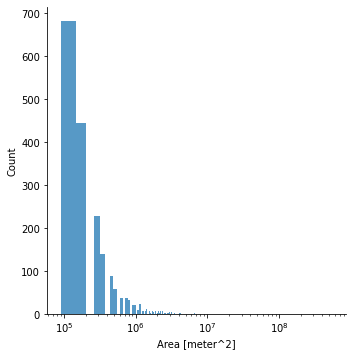

In [17]:
import seaborn as sns
sns.displot(patch_metrics["area"])
plt.xlabel("Area [meter^2]")
plt.semilogx();

We can also investigate the dimensionless metrics `shape_index`, `fractal_dimension`.

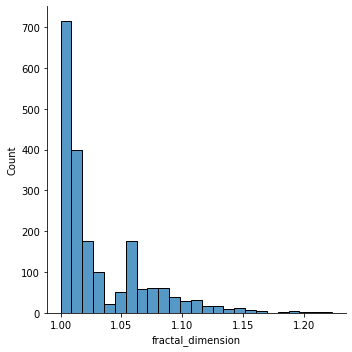

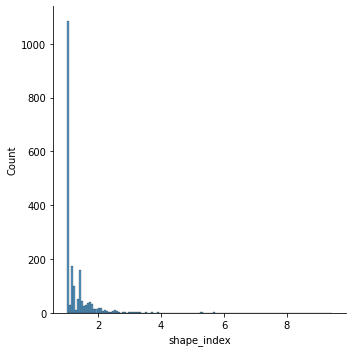

In [18]:
sns.displot(patch_metrics["fractal_dimension"])
sns.displot(patch_metrics["shape_index"]);

Further, we can easily analyse distributions for certain classes.

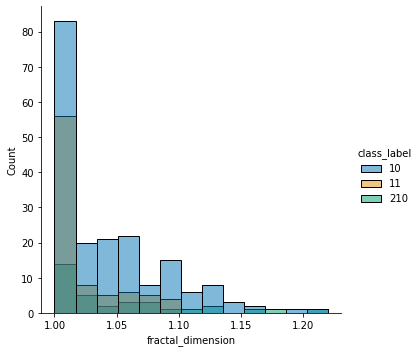

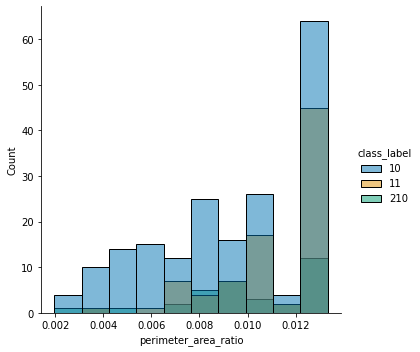

In [19]:
sns.displot(patch_metrics[classes_of_interest], x="fractal_dimension", hue="class_label", palette="colorblind")
sns.displot(patch_metrics[classes_of_interest], x="perimeter_area_ratio", hue="class_label", palette="colorblind");